In [1]:
# Import standard libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary sklearn functions and classes
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, learning_curve, validation_curve
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, make_scorer, explained_variance_score
)
from scipy.stats import randint, uniform

# Import additional libraries for diagnostics and stats
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting styles
plt.style.use('seaborn')

# For error analysis
from scipy.stats import zscore

/var/folders/gb/h6936f_53x1_5xpd2267nqc80000gn/T/ipykernel_18081/3742994017.py:26: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
# Load the cleaned DataFrame from the CSV file
df_pca_combined = pd.read_csv('df_pca_combined.csv')

# Utility Functions

In [3]:
# Utility functions
def prepare_data(df, target_column):  
    # Prepare data for machine learning
    X = df.drop(columns=[target_column])
    y = df[target_column]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def adjusted_r2_score(y_true, y_pred, X):
    n = len(y_true)
    p = X.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def evaluate_model(y_true, y_pred, X, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2_score(y_true, y_pred, X)
    
    metrics = {
        'Dataset': dataset_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2,
        'Adjusted R²': adj_r2,
        'Training Time': None  # Placeholder, will be updated in model scripts
    }
    return metrics

def plot_learning_curve(model, X_train, y_train):
    train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    train_scores_mean = -train_scores.mean(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)
    
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', label="Cross-validation score")
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def plot_validation_curve(model, X_train, y_train, param_name, param_range):
    train_scores, val_scores = validation_curve(model, X_train, y_train, param_name=param_name, param_range=param_range, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    train_scores_mean = -train_scores.mean(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)
    
    plt.figure()
    plt.plot(param_range, train_scores_mean, 'o-', label="Training score")
    plt.plot(param_range, val_scores_mean, 'o-', label="Cross-validation score")
    plt.title(f"Validation Curve for {param_name}")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure()
    plt.scatter(y_pred, residuals)
    plt.hlines(0, xmin=y_pred.min(), xmax=y_pred.max(), linestyles='dashed')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.grid()
    plt.show()

def plot_prediction_vs_actual(y_true, y_pred):
    plt.figure()
    plt.scatter(y_true, y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Prediction vs Actual")
    plt.grid()
    plt.show()

def save_results_to_csv(results, filename='model_results.csv'):
    df_results = pd.DataFrame(results)
    df_results.to_csv(filename, index=False)

def plot_metrics(results):
    results_df = pd.DataFrame(results)
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.barplot(data=results_df.melt(id_vars='Dataset', value_vars=['RMSE', 'MAE', 'R²']), x='variable', y='value', hue='Dataset', ax=ax)
    ax.set_title('Model Performance Comparison', fontsize=20)
    ax.set_ylabel('Score', fontsize=15)
    ax.set_xlabel('Metrics', fontsize=15)
    ax.legend(title='Model', title_fontsize='13', fontsize='11')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.show()

def plot_timing(results):
    results_df = pd.DataFrame(results)
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.barplot(data=results_df, x='Dataset', y='Training Time', palette='viridis', ax=ax)
    ax.set_title('Model Training Time Comparison', fontsize=20)
    ax.set_ylabel('Time (seconds)', fontsize=15)
    ax.set_xlabel('Model', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.show()

def error_analysis(y_true, predictions, model_name):
    error = y_true - predictions
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.histplot(error, bins=50, kde=True, color='coral', ax=ax)
    ax.set_title(f'Prediction Error Distribution for {model_name}', fontsize=20)
    ax.set_xlabel('Prediction Error', fontsize=15)
    ax.set_ylabel('Frequency', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.show()

# Random Forest

{'Dataset': 'Random Forest (Training)', 'MSE': 0.013791253937160568, 'RMSE': 0.11743616962912477, 'MAE': 0.0750490028596825, 'MAPE': 42.9061661647428, 'R²': 0.9861030960575137, 'Adjusted R²': 0.9859119722794102, 'Training Time': 222.3095030784607}
{'Dataset': 'Random Forest (Validation)', 'MSE': 0.02688914370384914, 'RMSE': 0.1639790953257431, 'MAE': 0.10674650695045988, 'MAPE': 54.09632223964989, 'R²': 0.9733007851326447, 'Adjusted R²': 0.9721674307056223, 'Training Time': None}
{'Dataset': 'Random Forest (Test)', 'MSE': 0.025067087905085654, 'RMSE': 0.15832589145520595, 'MAE': 0.1080065153418867, 'MAPE': 76.83996011813542, 'R²': 0.975523890003175, 'Adjusted R²': 0.9744857515693781, 'Training Time': None}

Cross-Validation Results (5-fold):
MSE: 0.02742083261531355 ± 0.004059880854998427
RMSE: 0.1651722589109193 ± 0.011788023650204704
MAE: -0.11065641030216145 ± 0.006039837852741433
MAPE: 58.2036931996483 ± 9.966683279647226
R²: 0.9724128857627438 ± 0.0036298593612372155


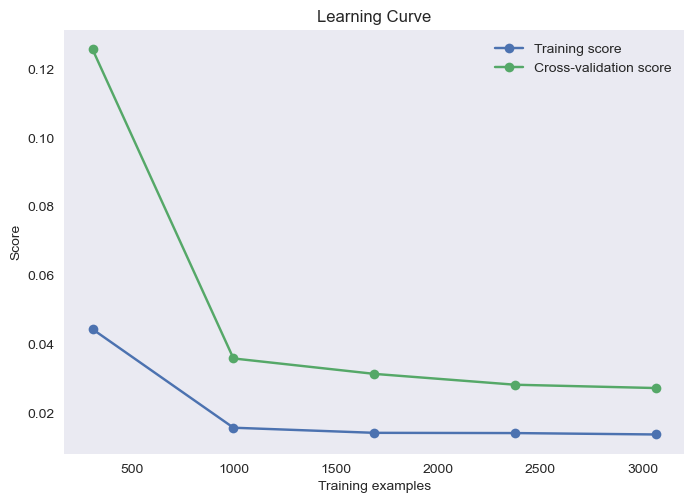

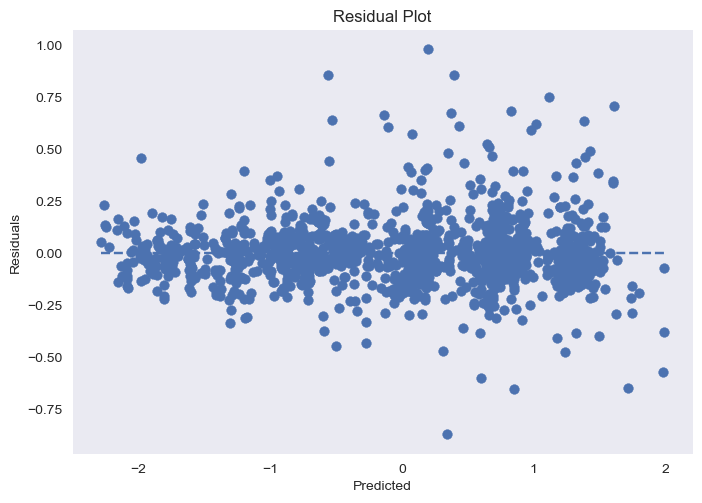

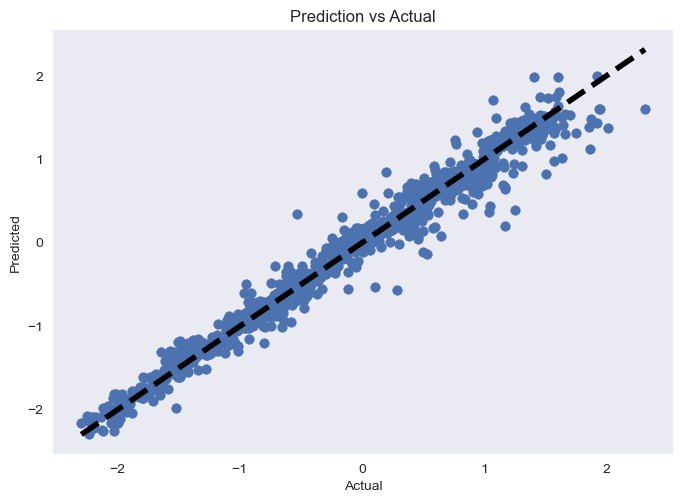

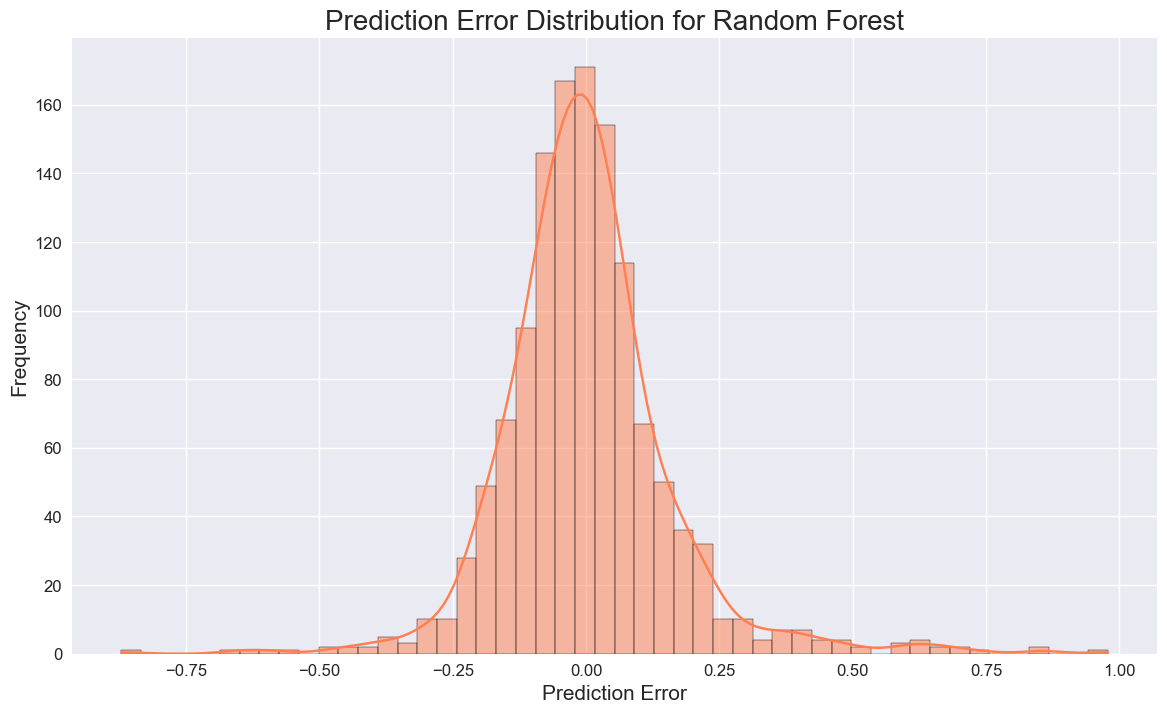

In [4]:
# Define the function to run the Random Forest model with Randomized Search and separated metrics
def run_random_forest(df_pca_combined, target_column='Weekly_Sales', results_filename='random_forest_results.csv'):
    df_randforest = df_pca_combined.copy()  # Create a copy of the dataframe
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_randforest, target_column)
    
    # Define the parameter distribution for Randomized Search
    param_dist = {
        'n_estimators': randint(100, 500),
        'max_depth': randint(1, 50),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 10)
    }

    # Set up the RandomizedSearchCV with Random Forest
    random_search = RandomizedSearchCV(
        RandomForestRegressor(random_state=42),
        param_dist,
        n_iter=50,
        cv=5,
        scoring='neg_mean_squared_error',
        random_state=42,
        n_jobs=-1
    )
    
    start_time = time.time()
    random_search.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Best model from Randomized Search
    best_model = random_search.best_estimator_

    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)
    y_test_pred = best_model.predict(X_test)

    # Evaluate model (Inter-model comparison metrics)
    rf_train_metrics = evaluate_model(y_train, y_train_pred, X_train, 'Random Forest (Training)')
    rf_val_metrics = evaluate_model(y_val, y_val_pred, X_val, 'Random Forest (Validation)')
    rf_test_metrics = evaluate_model(y_test, y_test_pred, X_test, 'Random Forest (Test)')

    # Create results list only for inter-model comparison metrics
    results = [
        {**rf_train_metrics, 'Training Time': training_time},
        rf_val_metrics,
        rf_test_metrics
    ]

    save_results_to_csv(results, results_filename)
    
    # Print inter-model comparison results
    for result in results:
        print(result)

    # Perform 5-fold cross-validation for pre-inter-model comparison metrics
    cv_results = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_mse = -cv_results
    cv_rmse = np.sqrt(cv_mse)
    cv_mae = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    cv_mape = cross_val_score(best_model, X_train, y_train, cv=5, scoring=make_scorer(mean_absolute_percentage_error))
    cv_r2 = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')

    # Print additional cross-validation metrics separately (not included in the results list)
    print("\nCross-Validation Results (5-fold):")
    print(f"MSE: {cv_mse.mean()} ± {cv_mse.std()}")
    print(f"RMSE: {cv_rmse.mean()} ± {cv_rmse.std()}")
    print(f"MAE: {cv_mae.mean()} ± {cv_mae.std()}")
    print(f"MAPE: {cv_mape.mean()} ± {cv_mape.std()}")
    print(f"R²: {cv_r2.mean()} ± {cv_r2.std()}")

    # Plot learning curve
    plot_learning_curve(best_model, X_train, y_train)
    
    # Plot residuals
    plot_residuals(y_test, y_test_pred)
    
    # Plot predicted vs actual values
    plot_prediction_vs_actual(y_test, y_test_pred)

    # Perform error analysis
    error_analysis(y_test, y_test_pred, 'Random Forest')

run_random_forest(df_pca_combined)